# import data and libraries

In [1]:
using CSV, DataFrames, Plots, Random, DecisionTree, Statistics, LinearAlgebra, JuMP, Gurobi, NearestNeighbors

In [2]:
const GRB_ENV = Gurobi.Env(output_flag=0);

In [3]:
# load data, we have to keep the data for all the players
data = CSV.read("../data/Final/ratings/imputed/ratings_22_imputed.csv", DataFrame)
prediction_XGBoost = Array(CSV.read("../code/XGB_model_predictions.csv", DataFrame)) #use the best one in the end
prediction_linear = Array(CSV.read("../code/linear_model_predictions.csv", DataFrame)) #use the best one in the end
transfers = CSV.read("../data/Transfers/all_transfers.csv", DataFrame);

In [4]:
# transform data in million euros
data[!, :value_eur] = data[!, :value_eur] ./ 1000000;

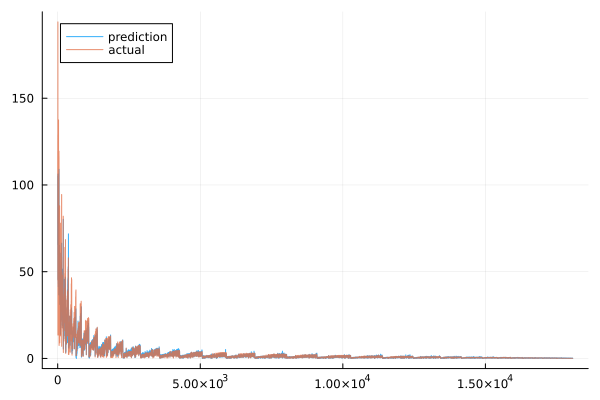

In [5]:
# understand prediciton distribution
plot(prediction_XGBoost, label="prediction", legend=:topleft, alpha = 0.8)
plot!(data[:, "value_eur"], label="actual", legend=:topleft, alpha = 0.8)

In [6]:
# save plot
savefig("../visualizations/prediction_actual_XGBoost.png")

"/Users/andreazanon/MachineLearning_Project/visualizations/prediction_actual_XGBoost.png"

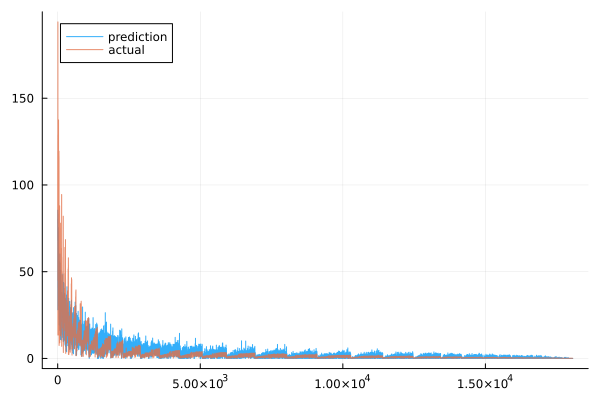

In [7]:
# understand prediciton distribution
plot(prediction_linear, label="prediction", legend=:topleft, alpha = 0.8)
plot!(data[:, "value_eur"], label="actual", legend=:topleft, alpha = 0.8)

In [8]:
# save plot
savefig("../visualizations/prediction_actual_linear.png")

"/Users/andreazanon/MachineLearning_Project/visualizations/prediction_actual_linear.png"

In [9]:
size(prediction_XGBoost)

(18063, 1)

In [10]:
size(data)

(18063, 64)

In [11]:
data[1:5,:]

Row,short_name,club_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_M,position_D,position_G,attack_work_rate,defense_work_rate,year
,String31,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,L. Messi,Paris Saint-Germain,93.0,93.0,78.0,320000.0,34.0,170.0,72.0,1.0,2021.0,2023.0,0.0,4.0,4.0,5.0,1.443e8,85.0,92.0,91.0,95.0,34.0,65.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1.0,1.0,0.0,0.0,2.0,1.0,2022.0
2,R. Lewandowski,FC Bayern München,92.0,92.0,119.5,270000.0,32.0,185.0,81.0,1.0,2021.0,2023.0,1.0,4.0,4.0,5.0,1.972e8,78.0,92.0,79.0,86.0,44.0,82.0,71.0,95.0,90.0,85.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,79.0,77.0,93.0,82.0,90.0,85.0,76.0,86.0,87.0,81.0,49.0,95.0,81.0,90.0,88.0,35.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,1.0,0.0,0.0,0.0,3.0,2.0,2022.0
3,Cristiano Ronaldo,Manchester United,91.0,91.0,45.0,270000.0,36.0,187.0,83.0,1.0,2021.0,2023.0,1.0,4.0,5.0,5.0,8.33e7,87.0,94.0,80.0,88.0,34.0,75.0,87.0,95.0,90.0,80.0,86.0,88.0,81.0,84.0,77.0,88.0,85.0,88.0,86.0,94.0,74.0,94.0,95.0,77.0,77.0,93.0,63.0,29.0,95.0,76.0,88.0,95.0,24.0,32.0,24.0,7.0,11.0,15.0,14.0,11.0,1.0,0.0,0.0,0.0,3.0,1.0,2022.0
4,Neymar Jr,Paris Saint-Germain,91.0,91.0,129.0,270000.0,29.0,175.0,68.0,1.0,2021.0,2025.0,1.0,5.0,5.0,5.0,2.387e8,91.0,83.0,86.0,94.0,37.0,63.0,85.0,83.0,63.0,86.0,86.0,95.0,88.0,87.0,81.0,95.0,93.0,89.0,96.0,89.0,84.0,80.0,64.0,81.0,53.0,81.0,63.0,37.0,86.0,90.0,93.0,93.0,35.0,32.0,29.0,9.0,9.0,15.0,15.0,11.0,1.0,1.0,0.0,0.0,3.0,2.0,2022.0
5,K. De Bruyne,Manchester City,91.0,91.0,125.5,350000.0,30.0,181.0,70.0,1.0,2021.0,2025.0,1.0,5.0,4.0,4.0,2.322e8,76.0,86.0,93.0,88.0,64.0,78.0,94.0,82.0,55.0,94.0,82.0,88.0,85.0,83.0,93.0,91.0,76.0,76.0,79.0,91.0,78.0,91.0,63.0,89.0,74.0,91.0,76.0,66.0,88.0,94.0,83.0,89.0,68.0,65.0,53.0,15.0,13.0,5.0,10.0,13.0,0.0,1.0,0.0,0.0,3.0,3.0,2022.0


In [12]:
# iterate over all clubs, and save players that are part of that clubs
club_players = Dict()
for club in Set(data[:, "club_name"])
    club_players[club] = data[data[:, "club_name"] .== club, :]
end

In [13]:
function true_transfers(club_choosen_transferName, transfers)

    # useful to compare our model with what truly happens
    transfers_club = transfers[transfers[:, "club_name"] .== club_choosen_transferName, :]
    transfers_club = transfers_club[completecases(transfers_club), :]

    transfers_in = transfers_club[transfers_club[:, "transfer_movement"] .== "in", :]

    transfers_out = transfers_club[transfers_club[:, "transfer_movement"] .== "out", :]

    return transfers_in, transfers_out

end

true_transfers (generic function with 1 method)

In [14]:
# keep only 2022 transfers
transfers = transfers[transfers[:, "year"] .== 2022, :];

# Choose club we are making prescription for

When we do prescription, we are pretending to be one specific club. We can do the same for multiple clubs.

In [15]:
data[1:10,:]

Row,short_name,club_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_M,position_D,position_G,attack_work_rate,defense_work_rate,year
,String31,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,L. Messi,Paris Saint-Germain,93.0,93.0,78.0,320000.0,34.0,170.0,72.0,1.0,2021.0,2023.0,0.0,4.0,4.0,5.0,1.443e8,85.0,92.0,91.0,95.0,34.0,65.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1.0,1.0,0.0,0.0,2.0,1.0,2022.0
2,R. Lewandowski,FC Bayern München,92.0,92.0,119.5,270000.0,32.0,185.0,81.0,1.0,2021.0,2023.0,1.0,4.0,4.0,5.0,1.972e8,78.0,92.0,79.0,86.0,44.0,82.0,71.0,95.0,90.0,85.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,79.0,77.0,93.0,82.0,90.0,85.0,76.0,86.0,87.0,81.0,49.0,95.0,81.0,90.0,88.0,35.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,1.0,0.0,0.0,0.0,3.0,2.0,2022.0
3,Cristiano Ronaldo,Manchester United,91.0,91.0,45.0,270000.0,36.0,187.0,83.0,1.0,2021.0,2023.0,1.0,4.0,5.0,5.0,8.33e7,87.0,94.0,80.0,88.0,34.0,75.0,87.0,95.0,90.0,80.0,86.0,88.0,81.0,84.0,77.0,88.0,85.0,88.0,86.0,94.0,74.0,94.0,95.0,77.0,77.0,93.0,63.0,29.0,95.0,76.0,88.0,95.0,24.0,32.0,24.0,7.0,11.0,15.0,14.0,11.0,1.0,0.0,0.0,0.0,3.0,1.0,2022.0
4,Neymar Jr,Paris Saint-Germain,91.0,91.0,129.0,270000.0,29.0,175.0,68.0,1.0,2021.0,2025.0,1.0,5.0,5.0,5.0,2.387e8,91.0,83.0,86.0,94.0,37.0,63.0,85.0,83.0,63.0,86.0,86.0,95.0,88.0,87.0,81.0,95.0,93.0,89.0,96.0,89.0,84.0,80.0,64.0,81.0,53.0,81.0,63.0,37.0,86.0,90.0,93.0,93.0,35.0,32.0,29.0,9.0,9.0,15.0,15.0,11.0,1.0,1.0,0.0,0.0,3.0,2.0,2022.0
5,K. De Bruyne,Manchester City,91.0,91.0,125.5,350000.0,30.0,181.0,70.0,1.0,2021.0,2025.0,1.0,5.0,4.0,4.0,2.322e8,76.0,86.0,93.0,88.0,64.0,78.0,94.0,82.0,55.0,94.0,82.0,88.0,85.0,83.0,93.0,91.0,76.0,76.0,79.0,91.0,78.0,91.0,63.0,89.0,74.0,91.0,76.0,66.0,88.0,94.0,83.0,89.0,68.0,65.0,53.0,15.0,13.0,5.0,10.0,13.0,0.0,1.0,0.0,0.0,3.0,3.0,2022.0
6,J. Oblak,Atlético de Madrid,91.0,93.0,112.0,130000.0,28.0,188.0,87.0,1.0,2021.0,2023.0,1.0,3.0,1.0,5.0,2.38e8,76.0214,54.9455,67.9747,65.2937,57.6166,74.4229,13.0,11.0,15.0,43.0,13.0,12.0,13.0,14.0,40.0,30.0,43.0,60.0,67.0,88.0,49.0,59.0,78.0,41.0,78.0,12.0,34.0,19.0,11.0,65.0,11.0,68.0,27.0,12.0,18.0,87.0,92.0,78.0,90.0,90.0,0.0,0.0,0.0,1.0,2.0,2.0,2022.0
7,K. Mbappé,Paris Saint-Germain,91.0,95.0,194.0,230000.0,22.0,182.0,73.0,1.0,2021.0,2022.0,1.0,4.0,5.0,4.0,3.735e8,97.0,88.0,80.0,92.0,36.0,77.0,78.0,93.0,72.0,85.0,83.0,93.0,80.0,69.0,71.0,91.0,97.0,97.0,92.0,93.0,83.0,86.0,78.0,88.0,77.0,82.0,62.0,38.0,92.0,82.0,79.0,88.0,26.0,34.0,32.0,13.0,5.0,7.0,11.0,6.0,1.0,0.0,0.0,0.0,3.0,1.0,2022.0
8,M. Neuer,FC Bayern München,90.

In [103]:
list_of_clubs = ["AC Milan", "FC Barcelona", "Paris Saint-Germain"]

club_name = list_of_clubs[3]

club_choosen = club_name
club_choosen_transferName = club_name
;

In [104]:
# get indexes of players in club club_choosen
index_club = data[:, "club_name"] .== club_choosen;

In [105]:
data_club = club_players[club_choosen]
data_rest = data[data[:, "club_name"] .!= club_choosen, :]
;

In [106]:
transfers_club = transfers[transfers[:, "club_name"] .== club_choosen_transferName, :];

In [107]:
pred_club_XGBoost = prediction_XGBoost[index_club]
pred_rest_XGBoost = prediction_XGBoost[Not(index_club)];

pred_club_linear = prediction_linear[index_club]
pred_rest_linear = prediction_linear[Not(index_club)];

In [108]:
function compute_improvement_age(m_o, a_o, m_c, a_c)

    transfers_in, transfers_out = true_transfers(club_choosen_transferName, transfers)

    # for each player in transfers_in find m_in and a_in
    m_in = []
    a_in = []
    for i in 1:size(transfers_in, 1)
        
        player = split(transfers_in[i, "player_name"], [' '])[end]
        
        m = 0.5 .* data_rest[contains.(data_rest[:, "short_name"], player), "overall"] .+ 0.5 .* data_rest[contains.(data_rest[:, "short_name"], player), "potential"]
        append!(m_in, m)
        append!(a_in, data_rest[contains.(data_rest[:, "short_name"], player), "age"])
    end

    # for each player in transfers_out find m_out and a_out
    m_out = []
    a_out = []
    for i in 1:size(transfers_out, 1)
        player = split(transfers_out[i, "player_name"], [' '])[end]

        m = 0.5 * data_club[contains.(data_club[:, "short_name"], player), "overall"] + 0.5 * data_club[contains.(data_club[:, "short_name"], player), "potential"]
        append!(m_out, m)
        append!(a_out, data_club[contains.(data_club[:, "short_name"], player), "age"])
    end

    delta = (sum(m_c) - sum(m_out) + sum(m_in)) / (length(m_c) + length(m_in) - length(m_out)) - mean(m_c)
    gamma = (sum(a_c) - sum(a_out) + sum(a_in)) / (length(a_c) + length(a_in) - length(a_out)) - mean(a_c)

    return delta, gamma
end

compute_improvement_age (generic function with 1 method)

In [109]:
# get parameters we need in our prescriptive model
function get_parameters(club_players, data_club, data_rest, transfers_club)
    n = size(data_rest, 1) # players that can be recruited
    N_c = k = size(data_club, 1) # number of players in the club, equal to how many we can consider to sell
    N_min = minimum([size(club_players[club])[1] for club in keys(club_players)]) # minimum number of players in the club
    N_max = maximum([size(club_players[club])[1] for club in keys(club_players)]) # maximum number of players in the club
    B_max = 10 # maximum number of players that can be bought
    S_max = 5 # maximum number of players that can be sold

    # for players outside the club
    p_o = data_rest[:, "potential"] # potential
    r_o = data_rest[:, "overall"] # rating
    true_o = data_rest[:, "value_eur"] # value (later we will use the value predicted in the prediction part)
    m_o = 0.2 .* r_o .+ 0.8 .* p_o # overall rating
    a_o = data_rest[:, "age"] # age

    # for players inside the club
    p_c = data_club[:, "potential"] # potential 
    r_c = data_club[:, "overall"] # rating 
    true_c = data_club[:, "value_eur"] # value (same as above)
    m_c = 0.2 .* r_c .+ 0.8 .* p_c # overall rating
    a_c = data_club[:, "age"] # age

    # compute how much transfers improved the quality of the team
    𝛅, 𝛾 = compute_improvement_age(m_o, a_o, m_c, a_c)
    # how much we want to improve the team
    # how much we can increase the average age at most

    return n, N_c, N_min, N_max, B_max, S_max, p_o, r_o, true_o, m_o, a_o, p_c, r_c, true_c, m_c, a_c, 𝛅, 𝛾
end

get_parameters (generic function with 1 method)

## Define functions that will be used across models

In [110]:
# define target and features
target = "fee";

In [111]:
function get_features(df)
    return select(df, Not(target))
end

get_features (generic function with 1 method)

In [112]:
function get_target(df)
    return df[:, target]
end

get_target (generic function with 1 method)

In [113]:
function compute_results(pred, test)
    # compute the mean absolute error
    mae = Metrics.mae(pred, test)
    # compute the mean squared error
    mse = Metrics.mse(pred, test)
    # compute the root mean squared error
    rmse = sqrt.(mse)
    # compute the r2
    osr2 = Metrics.r2_score(pred, test)

    # turn into dataframe
    results = DataFrame(mae = mae, mse = mse, rmse = rmse, osr2 = osr2)

    # print the results
    display(results)
end

compute_results (generic function with 1 method)

In [114]:
function check_prediction_value(pred, test)

    # set plot dimensions
    plot_size = (800, 400)
    
    histogram(pred, label = "pred", color = "red", seriesalpha = 0.5)
    display(histogram!(test, label = "test", color = "blue", seriesalpha = 0.5))

end

check_prediction_value (generic function with 1 method)

# What truly happened in the last transfer window

In [115]:
transfers_in, transfers_out = true_transfers(club_choosen_transferName, transfers)
revenue =  round(sum(transfers_out[:, "fee_cleaned"]) - sum(transfers_in[:, "fee_cleaned"]), digits = 0)

-93.0

# Approach 1: Regress and compare

In [116]:
data_club[1:5,:]

Row,short_name,club_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_M,position_D,position_G,attack_work_rate,defense_work_rate,year
,String31,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,L. Messi,Paris Saint-Germain,93.0,93.0,78.0,320000.0,34.0,170.0,72.0,1.0,2021.0,2023.0,0.0,4.0,4.0,5.0,1.443e8,85.0,92.0,91.0,95.0,34.0,65.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1.0,1.0,0.0,0.0,2.0,1.0,2022.0
2,Neymar Jr,Paris Saint-Germain,91.0,91.0,129.0,270000.0,29.0,175.0,68.0,1.0,2021.0,2025.0,1.0,5.0,5.0,5.0,2.387e8,91.0,83.0,86.0,94.0,37.0,63.0,85.0,83.0,63.0,86.0,86.0,95.0,88.0,87.0,81.0,95.0,93.0,89.0,96.0,89.0,84.0,80.0,64.0,81.0,53.0,81.0,63.0,37.0,86.0,90.0,93.0,93.0,35.0,32.0,29.0,9.0,9.0,15.0,15.0,11.0,1.0,1.0,0.0,0.0,3.0,2.0,2022.0
3,K. Mbappé,Paris Saint-Germain,91.0,95.0,194.0,230000.0,22.0,182.0,73.0,1.0,2021.0,2022.0,1.0,4.0,5.0,4.0,3.735e8,97.0,88.0,80.0,92.0,36.0,77.0,78.0,93.0,72.0,85.0,83.0,93.0,80.0,69.0,71.0,91.0,97.0,97.0,92.0,93.0,83.0,86.0,78.0,88.0,77.0,82.0,62.0,38.0,92.0,82.0,79.0,88.0,26.0,34.0,32.0,13.0,5.0,7.0,11.0,6.0,1.0,0.0,0.0,0.0,3.0,1.0,2022.0
4,G. Donnarumma,Paris Saint-Germain,89.0,93.0,119.5,110000.0,22.0,196.0,90.0,1.0,2021.0,2026.0,1.0,3.0,1.0,3.0,2.3e8,77.5313,57.1543,63.1662,72.7455,57.3173,69.1641,12.0,12.0,12.0,36.0,8.0,28.0,12.0,14.0,34.0,30.0,50.0,55.0,64.0,85.0,38.0,59.0,72.0,34.0,72.0,18.0,30.0,26.0,14.0,60.0,24.0,68.0,20.0,14.0,16.0,91.0,83.0,79.0,85.0,90.0,0.0,0.0,0.0,1.0,2.0,2.0,2022.0
5,Sergio Ramos,Paris Saint-Germain,88.0,88.0,24.0,115000.0,35.0,184.0,82.0,1.0,2021.0,2023.0,1.0,3.0,3.0,4.0,4.44e7,70.0,70.0,76.0,74.0,88.0,84.0,66.0,65.0,92.0,82.0,69.0,65.0,74.0,76.0,83.0,83.0,71.0,69.0,77.0,92.0,66.0,79.0,93.0,78.0,84.0,64.0,90.0,87.0,73.0,71.0,92.0,88.0,84.0,89.0,91.0,11.0,8.0,9.0,7.0,11.0,0.0,0.0,1.0,0.0,3.0,2.0,2022.0


In [117]:
function get_role(data)

    # get the role of each player
    att = data_club[:, "position_A"]
    mid = data_club[:, "position_M"]
    def = data_club[:, "position_D"]
    gk = data_club[:, "position_G"]

    return att, mid, def, gk
end

get_role (generic function with 1 method)

In [118]:
function get_range_role(data)
    a = []
    m = []
    d = []
    g = []

    for club in keys(club_players)

        append!(a, length(findall(x -> x == 1, club_players[club][:, "position_A"])))
        append!(m, length(findall(x -> x == 1, club_players[club][:, "position_M"])))
        append!(d, length(findall(x -> x == 1, club_players[club][:, "position_D"])))
        append!(g, length(findall(x -> x == 1, club_players[club][:, "position_G"])))
    end

    return round(std(a)), round(std(m)), round(std(d)), round(std(g))
end

get_range_role (generic function with 1 method)

In [119]:
function regress_and_compare(data_club, data_rest, transfers_club, 𝛅, what, pred_club, pred_rest)

    # get parameters
    n, k, N_min, N_max, B_max, S_max, p_o, r_o, true_o, m_o, a_o, p_c, r_c, true_c, m_c, a_c, delta, 𝛾 = get_parameters(club_players, data_club, data_rest, transfers_club)

    N_c = k
    # if what == true, means we are using the true value, otherwise we are using the prediction
    if what
        v_o = true_o
        v_c = true_c
    else
        v_o = pred_rest
        v_c = pred_club
    end

    # get sets of attackers, midfielders, defenders and goalkeepers inside the club
    att_c, mid_c, def_c, gk_c = get_role(data_club)
    # get number of players in each
    n_att_c = length(findall(x -> x == 1, att_c))
    n_mid_c = length(findall(x -> x == 1, mid_c))
    n_def_c = length(findall(x -> x == 1, def_c))
    n_gk_c = length(findall(x -> x == 1, gk_c))
    # get sets of attackers, midfielders, defenders and goalkeepers outside the club
    att_o, mid_o, def_o, gk_o = get_role(data_rest)
    # get number of players in each
    n_att_o = length(findall(x -> x == 1, att_o))
    n_mid_o = length(findall(x -> x == 1, mid_o))
    n_def_o = length(findall(x -> x == 1, def_o))
    n_gk_o = length(findall(x -> x == 1, gk_o))


    # get the range of the number of players in each role
    a_range, m_range, d_range, g_range = get_range_role(club_players)

    ### MODEL ### 
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model, "OutputFlag" => 0, "TimeLimit" => 12)

    ### VARIABLES ###
    @variable(model, b[i = 1:n], Bin) # 1 if we buy player i, 0 otherwise
    @variable(model, s[j = 1:k], Bin) # 1 if we sell player j, 0 otherwise

    ### OBJECTIVE ###
    @objective(model, Max, sum(s[j] * v_c[j] for j = 1:k) - sum(b[i] * v_o[i] for i = 1:n))
    
    ### CONSTRAINTS ###
    # improvement constraint
    @constraint(model, sum((1 - s[j]) * m_c[j] for j = 1:k) + sum(b[i] * m_o[i] for i = 1:n) >= (sum(m_c[j] for j = 1:k)/k + 𝛅) * (k + sum(b[i] for i = 1:n) - sum(s[j] for j = 1:k)))
    # maximum number of players that can be bought
    @constraint(model, sum(b[i] for i = 1:n) <= B_max)
    # maximum number of players that can be sold
    @constraint(model, sum(s[j] for j = 1:k) <= S_max) 
    # number of players in the club after the transfer window
    @constraint(model, N_min <= N_c + sum(b[i] for i = 1:n) - sum(s[j] for j = 1:k) <= N_max) 
    # average age of the team
    @constraint(model, sum((1 - s[j]) * a_c[j] for j = 1:k) + sum(b[i] * a_o[i] for i = 1:n) <= (sum(a_c[j] for j = 1:k)/k + 𝛾) * (k + sum(b[i] for i = 1:n) - sum(s[j] for j = 1:k)))
    # number of players in each role we have + we buy - we sell is within a range
    @constraint(model, - a_range <= sum(b[i] * att_o[i] for i = 1:n_att_o) - sum((s[j]) * att_c[j] for j = 1:n_att_c) <= a_range)
    @constraint(model, - m_range <= sum(b[i] * mid_o[i] for i = 1:n_mid_o) - sum((s[j]) * mid_c[j] for j = 1:n_mid_c) <= m_range)
    @constraint(model, - d_range <= sum(b[i] * def_o[i] for i = 1:n_def_o) - sum((s[j]) * def_c[j] for j = 1:n_def_c) <= d_range)    
    @constraint(model, - g_range <= sum(b[i] * gk_o[i] for i = 1:n_gk_o) - sum(s[j] * gk_c[j] for j = 1:n_gk_c) <= g_range)
    # solve model
    optimize!(model)

    return objective_value(model), value.(b), value.(s)
end

regress_and_compare (generic function with 1 method)

In [120]:
# run models for different values of delta
d = []
result_true = []
result_pred = []
bought_true = []
bought_pred = []
sold_true = []
sold_pred = []
delta_range = [n/10 for n in range(-7,20)]


for delta in delta_range
    obj_true, b_true, s_true = regress_and_compare(data_club, data_rest, transfers_club, delta, true, pred_club_XGBoost, pred_rest_XGBoost) # if true, considering true values
    obj_pred, b_pred, s_pred = regress_and_compare(data_club, data_rest, transfers_club, delta, false, pred_club_XGBoost, pred_rest_XGBoost) # false, considering predicted values
    push!(d, delta)
    push!(result_true, obj_true)
    push!(result_pred, obj_pred)
    push!(bought_true, b_true)
    push!(bought_pred, b_pred)
    push!(sold_true, s_true)
    push!(sold_pred, s_pred)
end

In [121]:
# for each predicted player, get his true value
bought_true_value = []
for b in bought_pred
    push!(bought_true_value, data_rest[b .== 1, "value_eur"])
end

sold_true_value = []
for s in sold_pred
    push!(sold_true_value, data_club[s .== 1, "value_eur"])
end

revenue = []
for i in 1:length(bought_true_value)
    append!(revenue, sum(sold_true_value[i]) - sum(bought_true_value[i]))
end

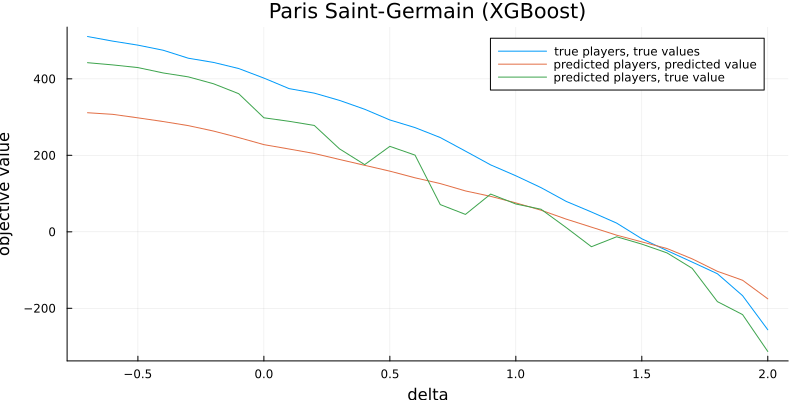

In [122]:
plot(d, result_true, label = "true players, true values", xlabel = "delta", ylabel = "objective value", title = club_choosen * " (XGBoost)", legend = :topright, size = (800, 400))
plot!(d, result_pred, label = "predicted players, predicted value")
plot!(d, revenue, label = "predicted players, true value")

In [123]:
# save plot
savefig("../visualizations/prescription_XGBoost_" * club_name * ".png")

"/Users/andreazanon/MachineLearning_Project/visualizations/prescription_XGBoost_Paris Saint-Germain.png"

In [124]:
# visualize results for a specific delta
𝛅 = 2

obj_true, b_true, s_true = regress_and_compare(data_club, data_rest, transfers_club, 𝛅, true, pred_club_XGBoost, pred_rest_XGBoost)
obj_pred, b_pred, s_pred = regress_and_compare(data_club, data_rest, transfers_club, 𝛅, false, pred_club_XGBoost, pred_rest_XGBoost);

In [125]:
# get the players that we buy and sell
buy_true = data_rest[b_true .== 1, :]
buy_pred = data_rest[b_pred .== 1, :];

In [126]:
sell_true = data_club[s_true .== 1, :]
sell_pred = data_club[s_pred .== 1, :];

In [127]:
# check intersection between players we buy_true and buy_pred
intersect_buy = intersect(buy_true[:, 1], buy_pred[:, 1])

3-element Vector{String31}:
 "E. Haaland"
 "R. Gravenberch"
 "Ansu Fati"

In [128]:
intersect_sell = intersect(sell_true[:, 1], sell_pred[:, 1])

3-element Vector{String31}:
 "Ander Herrera"
 "L. Kurzawa"
 "A. Letellier"

Now do the same with predictions using linear model

In [129]:
# run models for different values of delta
d_ = []
result_true_ = []
result_pred_ = []
bought_true_ = []
bought_pred_ = []
sold_true_ = []
sold_pred_ = []
delta_range_ = [n/10 for n in range(-7,20)]


for delta_ in delta_range_
    obj_true_, b_true_, s_true_ = regress_and_compare(data_club, data_rest, transfers_club, delta_, true, pred_club_linear, pred_rest_linear) # if true, considering true values
    obj_pred_, b_pred_, s_pred_ = regress_and_compare(data_club, data_rest, transfers_club, delta_, false, pred_club_linear, pred_rest_linear) # false, considering predicted values
    push!(d_, delta_)
    push!(result_true_, obj_true_)
    push!(result_pred_, obj_pred_)
    push!(bought_true_, b_true_)
    push!(bought_pred_, b_pred_)
    push!(sold_true_, s_true_)
    push!(sold_pred_, s_pred_)
end

In [130]:
# for each predicted player, get his true value
bought_true_value_ = []
for b_ in bought_pred_
    push!(bought_true_value_, data_rest[b_ .== 1, "value_eur"])
end

sold_true_value_ = []
for s_ in sold_pred_
    push!(sold_true_value_, data_club[s_ .== 1, "value_eur"])
end

revenue_ = []
for i in 1:length(bought_true_value_)
    append!(revenue_, sum(sold_true_value_[i]) - sum(bought_true_value_[i]))
end

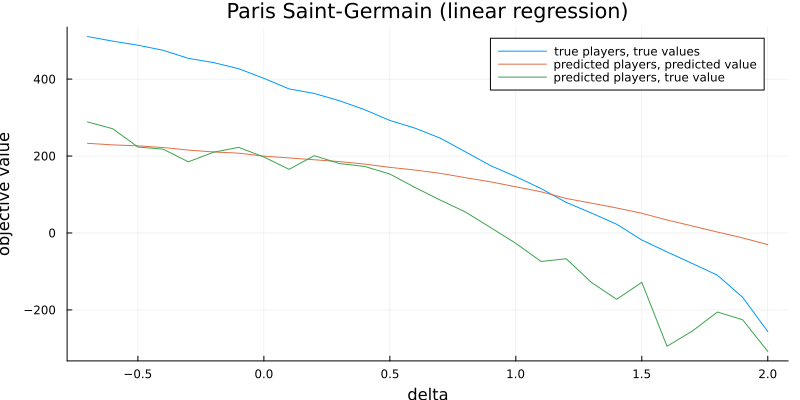

In [131]:
plot(d_, result_true_, label = "true players, true values", xlabel = "delta", ylabel = "objective value", title = club_choosen * " (linear regression)", legend = :topright, size = (800, 400))
plot!(d_, result_pred_, label = "predicted players, predicted value")
plot!(d_, revenue_, label = "predicted players, true value")

In [132]:
# save plot
savefig("../visualizations/prescription_linear_"* club_name*".png")

"/Users/andreazanon/MachineLearning_Project/visualizations/prescription_linear_Paris Saint-Germain.png"

# Useless because objective function is linear

## Approach 2: KNN

In [35]:
num_neighbors = 6
;

In [84]:
v = new_data[: , "value_eur"]; # find value for all players

In [85]:
# knn is not used for predicting the transfer fee, but for finding the nearest players to the one being considered
function find_nearest_neighbors(new_data)

    new_data = new_data[:, names(new_data) .!= "short_name"]
    new_data = new_data[: , names(new_data) .!= "club_name"]
    
    # train k-Nearest Neighbors Model
    df = vcat(train_valid, test)

    xDataTraining = Matrix(get_features(df))
    yDataTraining = get_target(df)

    xDataNew = Matrix(new_data)

    kdtree = KDTree(xDataTraining'; leafsize = 10)

    # indices returns for each player the indices of the k nearest neighbors
    indices, distance = knn(kdtree, xDataNew', num_neighbors)

    return indices
end

find_nearest_neighbors (generic function with 1 method)

In [83]:
function k_near_neigh(data_club, data_rest, transfers_club, num_neighbors)

    # get parameters
    n, N_c, N_min, N_max, B_max, S_max, p_o, r_o, v_o, m_o, a_o, p_c, r_c, v_c, m_c, a_c, 𝛅, 𝛾 = get_parameters(data_club, data_rest, transfers_club)

    # find nearest neighbors
    indices_club = find_nearest_neighbors(data_club)
    indices_rest = find_nearest_neighbors(data_rest)

    # define model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model, "OutputFlag" => 0, "TimeLimit" => 60)

    # define variables
    @variable(model, b[i = 1:n], Bin) # 1 if we buy player i, 0 otherwise
    @variable(model, s[j = 1:N_c], Bin) # 1 if we sell player j, 0 otherwise

    # define objective
    @objective(model, Max, sum(sum(s[j] * v[l] for l in indices_club[j]) / num_neighbors for j = 1:N_c) - 
            sum(sum(b[i] * v[l] for l in indices_rest[i]) / num_neighbors for i = 1:n))

    # define constraints
    @constraint(model, sum((1 - s[j]) * m_c[j] for j = 1:N_c) + sum(b[i] * m_o[i] for i = 1:n) >= (sum(m_c[j] for j = 1:N_c)/N_c + 𝛅) * (N_c + sum(b[i] for i = 1:n) - sum(s[j] for j = 1:N_c)))
    @constraint(model, sum(b[i] for i = 1:n) <= B_max) # maximum number of players that can be bought
    @constraint(model, sum(s[j] for j = 1:N_c) <= S_max) # maximum number of players that can be sold
    @constraint(model, N_min <= N_c + sum(b[i] for i = 1:n) - sum(s[j] for j = 1:N_c) <= N_max) # number of players in the club after the transfer window
    @constraint(model, sum((1 - s[j]) * a_c[j] for j = 1:N_c) + sum(b[i] * a_o[i] for i = 1:n) <= (sum(a_c[j] for j = 1:N_c)/N_c + 𝛾) * (N_c + sum(b[i] for i = 1:n) - sum(s[j] for j = 1:N_c))) # average age of the team

    # solve model
    optimize!(model)

    return objective_value(model), value.(b), value.(s)
end

k_near_neigh (generic function with 2 methods)

In [ ]:
obj_knn, b_knn, s_knn = k_near_neigh(data_club, data_rest, transfers_club, num_neighbors);

In [81]:
# get the players that we buy and sell
buy_knn = data_rest[b_knn .== 1, :]

Row,short_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_name,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_D,position_G,position_M,attack_work_rate,defense_work_rate
,String31,Int64,Int64,Float64,Float64,Int64,Int64,Int64,String,Float64,Int64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,K. Mbappé,91,95,1.94e8,230000.0,22,182,73,Paris Saint-Germain,1.0,2021,2022.0,1,4,5,4,3.735e8,97.0,88.0,80.0,92.0,36.0,77.0,78,93,72,85,83,93,80,69,71,91,97,97,92,93,83,86,78,88,77,82,62,38,92,82,79,88,26,34,32,13,5,7,11,6,1,0,0,0,3,1


In [82]:
sell_knn = data_club[s_knn .== 1, :]

Row,short_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_name,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_D,position_G,position_M,attack_work_rate,defense_work_rate
,String31,Int64,Int64,Float64,Float64,Int64,Int64,Int64,String,Float64,Int64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,S. Umtiti,80,80,1.95e7,125000.0,27,182,75,FC Barcelona,1.0,2021,2023.0,0,3,2,3,4.0e7,65.0,62.0,68.0,67.0,80.0,78.0,61,51,78,76,65,64,72,62,73,73,64,65,58,78,64,83,81,64,84,70,80,81,51,58,59,74,80,80,79,15,10,14,12,15,0,1,0,0,1,2
2,Álex Collado,67,79,2.5e6,33000.0,22,177,66,FC Barcelona,1.0,2021,2023.0,0,3,3,1,5.6e6,63.0,65.0,70.0,69.0,56.0,39.0,70,64,51,68,53,71,73,75,64,68,64,63,69,66,68,68,43,34,38,70,48,53,62,74,63,67,59,56,57,10,9,12,12,11,1,0,0,0,2,2
3,Gavi,66,85,2.1e6,4000.0,16,173,68,FC Barcelona,1.0,2021,2023.0,1,3,2,1,5.6e6,66.0,53.0,67.0,69.0,50.0,48.0,59,55,38,73,46,67,65,47,69,70,68,64,77,64,78,49,48,52,44,53,54,58,59,70,51,68,49,53,44,8,10,11,7,13,0,0,0,1,2,2


## Approach 3: CART and OCT